In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve2d
from scipy.misc import imresize

import tensorflow as tf

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = expanduser('~/data/images/Tkacik/cd01A')
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)
old_size = patches[0].shape[0]
height = 32
width = 32
resized_pixels_to_degree = float(height/old_size) * pixelsToDeg
images = [imresize(p, (height, width), interp='bilinear') for p in patches]

Only 70 files in directory.


In [3]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing = 1./pixelsToDeg # number of degree spacing between pixels
normalize = 'divisive'
contrast = 0.35
signal = np.array(np.load('signal_3_23.npy'))

In [4]:
signal.shape

(200,)

In [5]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = retina_width//photoreceptor_width
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

/home/lane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/home/lane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


In [6]:
len(freqs)

200

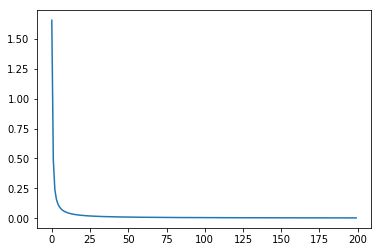

In [7]:
plt.plot(signal)

/home/lane/.local/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


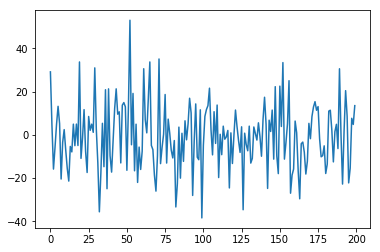

In [8]:
plt.plot(np.fft.rfft(np.random.randn(399)))

In [9]:
a = np.random.randn(399)

In [10]:
np.fft.rfft(a).shape

(200,)

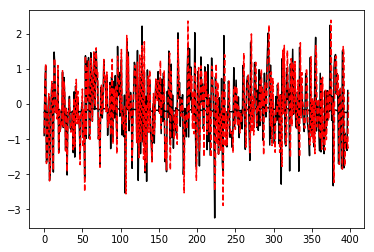

In [11]:
plt.plot(np.fft.irfft(np.fft.rfft(a)), 'k')
plt.plot(np.fft.irfft(np.fft.rfft(a) * signal), 'k')
plt.plot(a, 'r--')

In [12]:
def generate_spatial_signals(batch_size, signal=signal):
    # We generate white noise sequences, then multiply their frequency spectra
    # by the signal frequency spectra to make it look like a natural sequence.
    random_seq = [np.random.randn(2 * len(signal) - 1) for b in range(batch_size)]
    spatial_seq = [np.fft.irfft(np.fft.rfft(s) * signal) for s in random_seq]
    return np.stack(spatial_seq)

In [13]:
blah = generate_spatial_signals(32)

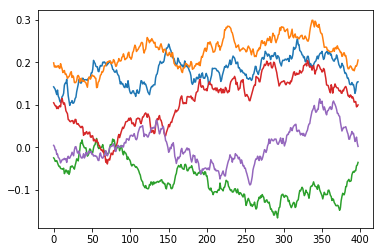

In [14]:
bloop = plt.plot(blah[:5].T)

# Get appropriately sized/shaped filters from retinal data.

In [15]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = int(retina_width/photoreceptor_width) - 1
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

In [16]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells(space_mode='peak')
cells['bipolar'] = load_bipolar_cells(space_mode='peak')
cells['amacrine'] = load_amacrine_cells(space_mode='peak')
cells['horizontal'] = load_horizontal_cells(space_mode='peak')

In [17]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for s, rf in cells[c]:
        this_cell_interp = interp1d(s, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(space))
        
average_ganglion_rf = np.mean(receptive_fields['ganglion'], axis=0)

In [18]:
data_path = expanduser('~/data/kastner/receptive_fields/')
spatialDelta = 0.05 # mm
micronsPerDeg = 50.
ganglion_rfs = {
    'fast_on': np.loadtxt(data_path + 'linesRF1.txt').reshape((126, 101, -1)),
    'fast_off_adapting': np.loadtxt(data_path + 'linesRF19.txt').reshape((-1, 101, 96)),
    'fast_off_sensitizing': np.loadtxt(data_path + 'linesRF8.txt').reshape((-1, 101, 96)),
    'medium_off_adapting': np.loadtxt(data_path + 'linesRF29.txt').reshape((-1, 101, 96)),
    'slow_off': np.loadtxt(data_path + 'linesRF17.txt').reshape((-1, 101, 96)),
}

for celltype in ganglion_rfs.keys():
    for rf in ganglion_rfs[celltype]:
        # since receptive fields are noisy, use PCA
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        this_space = get_space(g_pca, spatialDelta, micronsPerDeg, kind='peak')
        
        rf_interp = interp1d(this_space, sign_of_pc*g_pca, kind='slinear', bounds_error=False, fill_value=[0])

        receptive_fields[celltype].append(rf_interp(space))

In [19]:
corr_map = {}
for celltype in receptive_fields.keys():
    corr_map[celltype] = np.zeros((len(receptive_fields[celltype]), len(receptive_fields[celltype])))
    for idr1, rf1 in tqdm(enumerate(receptive_fields[celltype])):
        for idr2 in range(idr1+1, len(receptive_fields[celltype])):
            rf2 = receptive_fields[celltype][idr2]
            corr_map[celltype][idr1, idr2] = pearsonr(rf1, rf2)[0]

unduplicated_receptive_fields = collections.defaultdict(list)
duplicates = collections.defaultdict(list)

for celltype in corr_map.keys():
    these_dups = []
    for row in corr_map[celltype]:
        these_dups.append([i for i in range(len(row)) if row[i] == 1.0])
    duplicates[celltype] = np.unique(np.hstack(these_dups))
    
unduplicated_receptive_fields = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    for idr, rf in enumerate(receptive_fields[celltype]):
        if idr not in duplicates[celltype]:
            unduplicated_receptive_fields[celltype].append(rf)
            
receptive_fields = unduplicated_receptive_fields.copy()
del unduplicated_receptive_fields

28it [00:00, 872.70it/s]
2it [00:00, 12483.05it/s]
2it [00:00, 7825.19it/s]
2it [00:00, 11066.77it/s]
126it [00:00, 196.92it/s]
772it [00:24, 31.03it/s] 
249it [00:02, 96.37it/s] 
321it [00:04, 74.51it/s] 
253it [00:02, 93.72it/s] 


In [ ]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0)
def center_and_surround(space, center_width, surround_width, center_strength, surround_strength):
    return diff_of_gauss_mu0(space, abs(center_width), abs(surround_width),
                            -abs(center_strength), abs(surround_strength))

In [ ]:
center_widths = collections.defaultdict(list)
surround_widths = collections.defaultdict(list)
center_strengths = collections.defaultdict(list)
surround_strengths = collections.defaultdict(list)
fit_failures = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        
        for idg, g in tqdm(enumerate(receptive_fields[celltype])):
            try:
                popt_this, pcov = curve_fit(center_and_surround, space, g, p0=[1.5, 3.5, -10, 30])
                center_id = np.argmin(abs(popt_this[:2]))
                surround_id = 1 ^ center_id
                center_widths[celltype].append(abs(popt_this[center_id]))
                surround_widths[celltype].append(abs(popt_this[surround_id]))
                center_strengths[celltype].append(popt_this[center_id+2])
                surround_strengths[celltype].append(popt_this[surround_id+2])
#                 plt.plot(space, diff_of_gauss_mu0(space, *popt_this), color=np.random.rand(3), alpha=0.6)
            except:
                fit_failures[celltype].append(idg)
            
                # just set params to median across cells
                # this way the params are still aligned with the receptive field id
                center_widths[celltype].append(np.median(center_widths[celltype]))
                surround_widths[celltype].append(np.median(surround_widths[celltype]))
                center_strengths[celltype].append(np.median(center_strengths[celltype]))
                surround_strengths[celltype].append(np.median(surround_strengths[celltype]))
                
#                 print("Couldn't fit cell %d" %idg)

28it [00:17,  1.45s/it]
58it [00:23,  3.02it/s]
365it [01:07,  1.07it/s]

In [ ]:
median_center_widths = {}
for celltype in center_widths.keys():
    cws = np.array(center_widths[celltype])
    sws = np.array(surround_widths[celltype])
    css = np.array(center_strengths[celltype])
    sss = np.array(surround_strengths[celltype])
#     mean_center_widths[celltype] = np.mean(cws[cws < 500])
#     mean_surround_width = np.mean(sws[sws < 500])
#     mean_center_strength = np.mean(css[abs(css) < 500])
#     mean_surround_strength = np.mean(sss[abs(sss) < 500])
    
    median_center_widths[celltype] = np.median(abs(cws))
    median_surround_width = np.median(abs(sws))
    median_center_strength = np.median(-abs(css))
    median_surround_strength = np.median(abs(sss))
#     plt.plot(space, diff_of_gauss_mu0(space, median_center_widths[celltype], median_surround_width,
#                                      median_center_strength, median_surround_strength), label=celltype)
# plt.legend(frameon=False, fontsize=9, loc='lower left')
# adjust_spines(plt.gca())

In [ ]:
horz_pfs_full = get_horizontal_projective_field(conv_mode='full')
horz_pfs_same = get_horizontal_projective_field(conv_mode='same')
ama_pfs_full = get_amacrine_projective_field(conv_mode='full')
ama_pfs_same = get_amacrine_projective_field(conv_mode='same')

space_h_full, horz_pf_full, horz_sem_full = get_mean(horz_pfs_full)
space_h_same, horz_pf_same, horz_sem_same = get_mean(horz_pfs_same)
space_a_full, ama_pf_full, ama_sem_full = get_mean(ama_pfs_full)
space_a_same, ama_pf_same, ama_sem_same = get_mean(ama_pfs_same)

In [ ]:
horz_pf_interp = interp1d(space_h_full, horz_pf_full, kind='slinear', bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space_a_full, ama_pf_full, kind='slinear', bounds_error=False, fill_value=[0])

horz_pf = horz_pf_interp(space)
ama_pf = ama_pf_interp(space)

In [ ]:
horz_pf /= np.sum(horz_pf)
ama_pf /= np.sum(ama_pf)

In [ ]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing = 1./pixelsToDeg # number of degree spacing between pixels
normalize = 'divisive'
contrast = 0.35
signal = np.array(np.load('signal_3_23.npy'))

In [ ]:
input_noise = 0.098762200628786892
output_noise = 0.35
target_power = 54.131410989171826

In [ ]:
plt.plot(signal, '.')

In [ ]:
fig = plt.gcf()
fig.set_size_inches((2,2))
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
print(get_snr(input_noise, output_noise, signal, 1000*average_ganglion_fft, mode='variance'))
snrs = [get_snr(input_noise, output_noise, signal, c*average_ganglion_fft) for c in np.linspace(0,50,100)]
plt.plot(np.linspace(0,50,100), snrs)
adjust_spines(plt.gca())
plt.xlabel('Arbitrary scaling of ganglion cell filter')
plt.ylabel('SNR')

# SNR = 0.269 is total SNR from ganglion recordings of 112 repeats to 30 seconds natural scenes
def find_filt_const(filt_const):
    this_snr = get_snr(input_noise, output_noise, signal, filt_const*average_ganglion_fft, mode='variance')
    return (this_snr - 0.26912469)**2

filt_const_opt = scipy.optimize.minimize_scalar(find_filt_const)

our_snr = get_snr(input_noise, output_noise, signal, filt_const_opt.x*average_ganglion_fft, mode='variance')

plt.scatter(filt_const_opt.x, our_snr, s=20, color='k')

In [ ]:
resolution = 150
horz_weights = np.linspace(0,1,resolution)
center_weights = np.linspace(0,1,resolution)

In [91]:
median_center_widths

{'fast_off_adapting': 1.6921005209471627,
 'fast_off_sensitizing': 2.0456543257003039,
 'fast_on': 2.1703662900605498,
 'ganglion': 1.3731413963691115,
 'medium_off_adapting': 1.555772399380934,
 'slow_off': 1.5248731503974167}

In [92]:
len(signal)

200

In [ ]:
init_filt_const = 10.9
info_maps = collections.defaultdict(list) # one info map per celltype (since they will be a function of center width)
failures = collections.defaultdict(list)
detailed_failures = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
        center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf
        
        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
        
#         print('Information map for %s cells.' %celltype)
        
        infomap = np.zeros((resolution, resolution))
        for idh,hw in tqdm(enumerate(horz_weights)):
            for idc,cw in enumerate(center_weights):
                rf = rf_model(hw, cw)
                rf_filt = abs(np.fft.rfft(rf))
                
                # constrain model
                def constrain_filt_power(filt_const):
                    size = len(rf_filt)
                    output_power = np.sum((signal*filt_const*rf_filt)**2 
                                          + (input_noise*filt_const*rf_filt)**2
                                          + output_noise**2)
                    
                    return (target_power - output_power)**2

                filt_const_opt = scipy.optimize.minimize(constrain_filt_power, init_filt_const)
                iterations = 0
                new_init_filt_const = init_filt_const
                while not filt_const_opt.success:
                    iterations += 1
                    new_init_filt_const *= 10
                    filt_const_opt = scipy.optimize.minimize(constrain_filt_power, new_init_filt_const)
                    if iterations > 10:
                        detailed_failures[celltype] = filt_const_opt
                        break
                
                filt_const = abs(filt_const_opt['x'])
                
                if not filt_const_opt.success:
                    failures[celltype].append([hw, cw])

                signal_power = (filt_const * rf_filt * signal)**2
                noise_power = (filt_const * rf_filt * input_noise)**2 + output_noise**2
                infomap[idh,idc] = 0.5*np.sum(np.log2(1 + signal_power/noise_power))
        info_maps[celltype] = infomap

In [ ]:
celltype = 'medium_off_adapting'
center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

def rf_model(horz_weight, center_weight):
    return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)

In [94]:
np.unravel_index(np.argmax(info_maps[celltype]), (resolution, resolution))

(7, 79)

In [93]:
info_maps[celltype][7, 79]

9.4127817834488958

In [95]:
horz_weights[7]

0.046979865771812082

In [96]:
center_weights[79]

0.53020134228187921

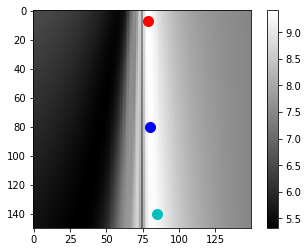

In [226]:
plt.imshow(info_maps[celltype], cmap='gray')
plt.plot([79], [7], 'r.', markersize=20)
# plt.plot([60], [7], 'y.', markersize=20)
# plt.plot([60], [130], 'g.', markersize=20)
plt.plot([80], [80], 'b.', markersize=20)
plt.plot([85], [140], 'c.', markersize=20)
plt.colorbar()

In [101]:
info_maps[celltype][7, 60]

5.4946557689000217

In [102]:
info_maps[celltype][130, 60]

7.2308688251805719

In [103]:
info_maps[celltype][7, 79]

9.4127817834488958

In [104]:
info_maps[celltype][80, 80]

9.3800150765770827

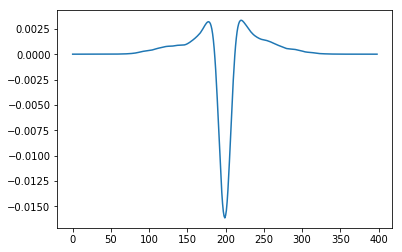

In [105]:
plt.plot(rf_model(0.5, 0.5))

# Gather collection of 1-D filters, sorted by information

In [106]:
chosen_center_weights = [79, 80, 85]
chosen_horz_weights = [7, 80, 140]
chosen_infos = []
chosen_filters = []
actual_cws = []
actual_hws = []
for cw, hw in zip(chosen_center_weights, chosen_horz_weights):
    chosen_infos.append(info_maps[celltype][hw, cw])
    actual_cws.append(center_weights[cw])
    actual_hws.append(horz_weights[hw])
    chosen_filters.append(rf_model(actual_hws[-1], actual_cws[-1]))

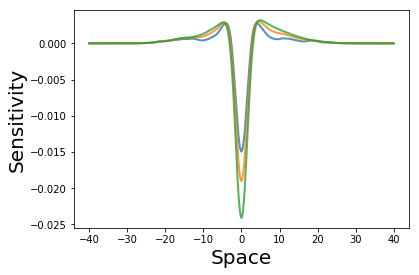

In [107]:
for f in chosen_filters:
    plt.plot(space, f, linewidth=2, alpha=0.8)
    plt.xlabel('Space', fontsize=20)
    plt.ylabel('Sensitivity', fontsize=20)

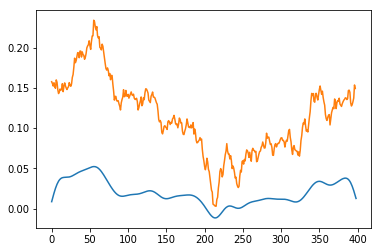

In [108]:
batch_size = 2
instance = generate_spatial_signals(batch_size, signal=signal)
plt.plot(np.convolve(f, instance[0], mode='same'))
plt.plot(-instance[0])

In [109]:
instance.shape

(2, 398)

In [162]:
def training_data(batch_size, diverse=False):
    original_instances = 10 * generate_spatial_signals(batch_size)
    instances = original_instances + input_noise * np.random.randn(*original_instances.shape)
    
    if diverse:
        convolved_instances = np.stack(
            [np.stack([np.convolve(f, inst, mode='same') for inst in instances]) for f in chosen_filters], axis=-1)
    else:
        convolved_instances = np.stack(
            [np.stack([np.convolve(chosen_filters[0],
                                   inst,
                                   mode='same') for inst in instances]) for fid in range(len(chosen_filters))],
            axis=-1)
    return (convolved_instances + output_noise * np.random.randn(*convolved_instances.shape), original_instances)

In [163]:
input_noise

0.09876220062878689

In [164]:
x, y = training_data(32, diverse=False)

In [165]:
y.shape

(32, 398)

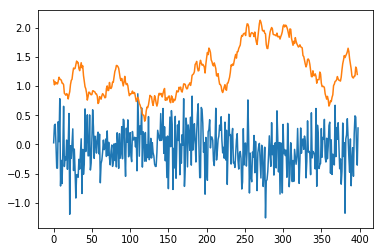

In [166]:
plt.plot(x[0, :, 0])
plt.plot(y[0])

In [167]:
np.var(y[0])

0.16352425993723751

In [168]:
np.var(x[0, :, 0])

0.13337035900317723

In [173]:
np.mean([np.var(y[j]) / (np.var(x[j, :, 0])) for j in range(32)])

1.7894370242620055

In [201]:
batch_size = 32
input_len = x.shape[1]
output_len = y.shape[1]
channel_depth = 3
max_steps = 30000
results = collections.defaultdict(list)
g = tf.Graph()
errors = []
with g.as_default():
    distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, channel_depth))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    # inputs, num_outputs, kernel_size, stride=1
    flattened_input = tf.contrib.layers.flatten(distortion)
    out = tf.layers.dense(flattened_input, output_len)
#     out = tf.layers.dense(layer1, 1)
    # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    # layer1 = tf.image.resize_bilinear(layer1, [height, width])
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(mse)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size, diverse=False)
            update, error = sess.run([train_op, mse], feed_dict={distortion: x, label: y})
            errors.append(error)
            if step % 500 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)

Error at step 0000 is 1.1931
Error at step 0500 is 1.1383
Error at step 1000 is 0.8170
Error at step 1500 is 0.8821
Error at step 2000 is 1.0188
Error at step 2500 is 1.0885
Error at step 3000 is 0.9787
Error at step 3500 is 1.1720
Error at step 4000 is 0.9236
Error at step 4500 is 0.7260
Error at step 5000 is 0.8414
Error at step 5500 is 0.6968
Error at step 6000 is 0.7874
Error at step 6500 is 0.8081
Error at step 7000 is 0.8029
Error at step 7500 is 0.8005
Error at step 8000 is 0.9147
Error at step 8500 is 0.8129
Error at step 9000 is 0.8032
Error at step 9500 is 0.7739
Error at step 10000 is 0.9574
Error at step 10500 is 0.8747
Error at step 11000 is 0.8458
Error at step 11500 is 0.8154
Error at step 12000 is 0.7705
Error at step 12500 is 0.6315
Error at step 13000 is 0.6427
Error at step 13500 is 0.7408
Error at step 14000 is 0.6367
Error at step 14500 is 0.7220
Error at step 15000 is 0.8082
Error at step 15500 is 0.6484
Error at step 16000 is 0.7545
Error at step 16500 is 0.7553


In [202]:
homogenous_results = results

In [176]:
out.shape

TensorShape([Dimension(32), Dimension(398)])

In [177]:
error

0.52711225

In [178]:
results['input'][-1].shape

(32, 399, 3)

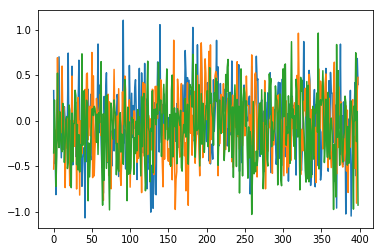

In [179]:
plt.plot(results['input'][-1][0])

In [180]:
results['output'][-1][0].shape

(398,)

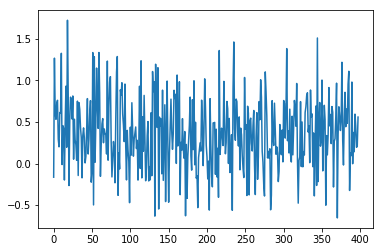

In [182]:
plt.plot(results['output'][-1][0])

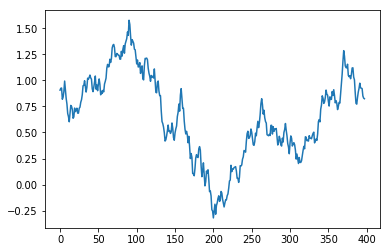

In [183]:
plt.plot(results['labels'][-1][0])

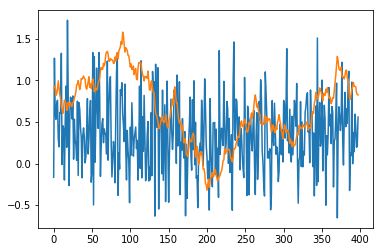

In [184]:
plt.plot(results['output'][-1][0])
plt.plot(results['labels'][-1][0])

In [187]:
np.mean([np.mean((results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])

0.50849285048391168

In [191]:
np.mean([np.var(results['labels'][-1][j]) for j in range(batch_size)])

0.19057612954024189

In [192]:
batch_size = 32
input_len = x.shape[1]
output_len = y.shape[1]
channel_depth = 3
max_steps = 30000
results = collections.defaultdict(list)
g = tf.Graph()
errors = []
with g.as_default():
    distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, channel_depth))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    # inputs, num_outputs, kernel_size, stride=1
    flattened_input = tf.contrib.layers.flatten(distortion)
    out = tf.layers.dense(flattened_input, output_len)
#     out = tf.layers.dense(layer1, 1)
    # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    # layer1 = tf.image.resize_bilinear(layer1, [height, width])
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(mse)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size, diverse=True)
            update, error = sess.run([train_op, mse], feed_dict={distortion: x, label: y})
            errors.append(error)
            if step % 500 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)

Error at step 0000 is 1.3392
Error at step 0500 is 0.9161
Error at step 1000 is 0.9808
Error at step 1500 is 1.1075
Error at step 2000 is 1.0778
Error at step 2500 is 0.9212
Error at step 3000 is 0.8315
Error at step 3500 is 0.6326
Error at step 4000 is 0.9599
Error at step 4500 is 0.7603
Error at step 5000 is 0.7335
Error at step 5500 is 0.7441
Error at step 6000 is 0.8873
Error at step 6500 is 0.5724
Error at step 7000 is 0.7249
Error at step 7500 is 0.6953
Error at step 8000 is 0.5876
Error at step 8500 is 0.5458
Error at step 9000 is 0.6870
Error at step 9500 is 0.5529
Error at step 10000 is 0.6191
Error at step 10500 is 0.5107
Error at step 11000 is 0.5527
Error at step 11500 is 0.5653
Error at step 12000 is 0.5259
Error at step 12500 is 0.5335
Error at step 13000 is 0.4827
Error at step 13500 is 0.5172
Error at step 14000 is 0.5025
Error at step 14500 is 0.4499
Error at step 15000 is 0.4647
Error at step 15500 is 0.4700
Error at step 16000 is 0.4473
Error at step 16500 is 0.3687


In [200]:
diverse_results = results

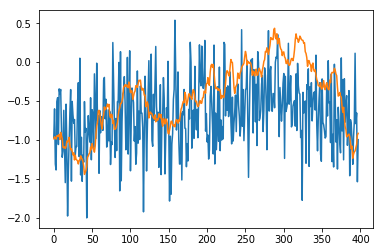

In [193]:
plt.plot(results['output'][-1][0])
plt.plot(results['labels'][-1][0])

In [194]:
np.mean([np.mean((results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])

0.34256938964974604

In [195]:
np.mean([np.var(results['labels'][-1][j]) for j in range(batch_size)])

0.17817949437431441

<Container object of 2 artists>

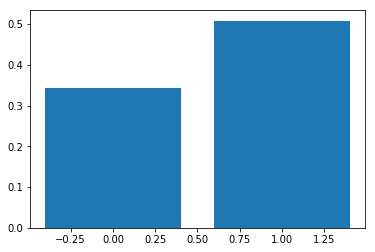

In [197]:
errors = 0
plt.bar([0, 1], [0.342, 0.508], color='k', yerr=errors)

# Collect results into errorbar chart

In [203]:
homogenous_mse = np.mean(
    [np.mean(
        (homogenous_results['output'][-1][j] - homogenous_results['labels'][-1][j])**2) for j in range(batch_size)])
diverse_mse = np.mean(
    [np.mean(
        (diverse_results['output'][-1][j] - diverse_results['labels'][-1][j])**2) for j in range(batch_size)])
homogenous_errors = sem(
    [np.mean(
        (homogenous_results['output'][-1][j] - homogenous_results['labels'][-1][j])**2) for j in range(batch_size)])
diverse_errors = sem(
    [np.mean(
        (diverse_results['output'][-1][j] - diverse_results['labels'][-1][j])**2) for j in range(batch_size)])

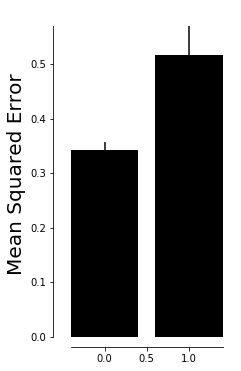

In [212]:
fig = plt.figure(figsize=(3,6))
plt.bar([0, 1], [diverse_mse, homogenous_mse], color='k', yerr=[diverse_errors, homogenous_errors])
plt.ylabel('Mean Squared Error', fontsize=20)
adjust_spines(plt.gca())

# Take the last N iterations

In [223]:
N = 3
homogenous_outputs = np.concatenate([homogenous_results['output'][-k] for k in range(N)])
homogenous_labels = np.concatenate([homogenous_results['labels'][-k] for k in range(N)])
diverse_outputs = np.concatenate([diverse_results['output'][-k] for k in range(N)])
diverse_labels = np.concatenate([diverse_results['labels'][-k] for k in range(N)])

In [224]:
homogenous_mse = np.mean([np.mean((homogenous_outputs[j] - homogenous_labels[j])**2) for j in range(N * batch_size)])
diverse_mse = np.mean([np.mean((diverse_outputs[j] - diverse_labels[j])**2) for j in range(N * batch_size)])
homogenous_errors = sem([np.mean((homogenous_outputs[j] - homogenous_labels[j])**2) for j in range(N * batch_size)])
diverse_errors = sem([np.mean((diverse_outputs[j] - diverse_labels[j])**2) for j in range(N * batch_size)])

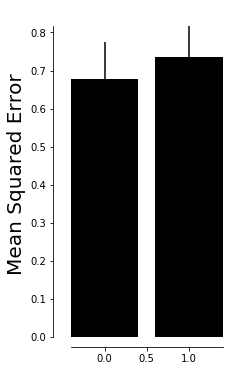

In [225]:
fig = plt.figure(figsize=(3,6))
plt.bar([0, 1], [diverse_mse, homogenous_mse], color='k', yerr=[diverse_errors, homogenous_errors])
plt.ylabel('Mean Squared Error', fontsize=20)
adjust_spines(plt.gca())

In [250]:
original_instances = 10 * generate_spatial_signals(batch_size)
instances = original_instances + input_noise * np.random.randn(*original_instances.shape)

convolved_instances = np.stack(
    [np.stack([np.convolve(f, inst, mode='same') for inst in instances]) for f in chosen_filters], axis=-1)
blah =  (convolved_instances + output_noise * np.random.randn(*convolved_instances.shape), original_instances)

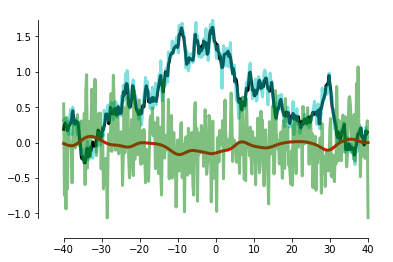

In [258]:
plt.plot(space[:-1], original_instances[0], linewidth=3, c='k')
plt.plot(space[:-1], instances[0], linewidth=3, c='c', alpha=0.5)
plt.plot(space, convolved_instances[0, :, 0], linewidth=3, c='r')
plt.plot(space, blah[0][0, :, 0], linewidth=3, c='g', alpha=0.5)
adjust_spines(plt.gca())